# Confidence interval approximations for the AUROC

The area under the receiver operating curve (AUROC) is one of the most commonly used performance metrics for binary classification. Visually, the AUROC is the integral between the sensitivity and false positive rate curves across all thresholds for a binary classifier. The AUROC can also be shown to be equivalent to an instance of the [Mann-Whitney-U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (MNU), a non-parametric rank-based statistic. This post addresses two challenges when doing statistical testing for the AUROC: i) how to speed up the calculation of the AUROC, and ii) which inference procedure to use to obtain the best possible coverage. The AUROC's relationship to the MNU will be shown to be important for both speed ups in calculation and resampling approaches for the bootstrap.

## (1) Methods for calculating the AUROC

In the binary classification paradigm a model produces a score associated with the probability that an observation belongs to class 1 (as opposed to class 0). The AUROC of any model is a probabilistic term: $P(s^1 > s^0)$, where $s^k$ is the distribution of scores from the model for class $k$. In practice the AUROC is never known because the distribution of data is unknown! However, an unbiased estimate of the AUROC (a.k.a the empirical AUROC) can be calculated through one of several approaches. 

The first method is to draw the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) by measuring the sensitivity/specificity across all thresholds, and then using the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) for calculating the integral. This approach is computationally inefficient and should only be done for visualization purposes. A second method to obtain the empirical AUROC is to simply calculate the percentage of times the positive class score exceeds the negative class score:

$$
\begin{align}
AUC &= \frac{1}{n_1n_0} \sum_{i: y_i=1} \sum_{j: y_j=0} I(s_i > s_j) + 0.5\cdot I(s_i = s_j) \label{eq:auc_pair}
\end{align}
$$

Where $y_i$ is the binary label for the $i^{th}$ observation and $n_k$ is the number of instances for class $k$. If we assume that the positive class is some fraction of the observation in the population: $P(y=1) = c$, then on average, calculating the AUROC via \eqref{eq:auc_pair} requires $c(1-c)n^2$ operations which means $O(AUC)=n^2$. For larger sample sizes this quadratic complexity will lead to long run times. One method to bound the computational complexity of \eqref{eq:auc_pair} is to randomly sample, with replacement, $m$ samples from each class the data to get a stochastic approximation of the AUC.

$$
\begin{align}
\tilde{AUC} &= \frac{1}{m} \sum_{i} P(\tilde{s_i}^1 > \tilde{s_i}^0) \label{eq:auc_rand}
\end{align}
$$

Where $\tilde{s_i}^k$ is a random instance from the scores of class $k$. The stochastic AUROC approach has the nice computational advantage that it is $O(m)$. As with other stochastic methods, \eqref{eq:auc_rand} requires knowledge of the sampling variation of the statistic and seeding, which tends to discourage its use in practice. This post will encourage the use of the rank order of the data to calculate the empirical AUROC. 

$$
\begin{align}
rAUC &= \frac{1}{n_1n_0} \sum_{i: y_i=1} r_i - \frac{n_1(n_1 +1)}{2} \label{eq:auc_rank}
\end{align}
$$

Where $r_i$ is the sample rank of the data. Since ranking a vector is $O(n\log n)$, the computational complexity of \eqref{eq:auc_rank} is linearithmic, which will mean significant speed ups over \eqref{eq:auc_pair}. 

## (2) Run-time comparisons

The code block below shows the run-times for the different approaches, ....


with the stochastic approach using $m = 5 n$. Random processes with known AUROCs will be generated in advance with the Gaussian and Exponential distributions. For the normal distribution, 

$$
\begin{align*}
s_i^0 \sim N(0,1)&, \hspace{2mm} s_i^1 \sim N(\mu,1), \hspace{2mm} \mu \geq 0, \\
P(s_i^1 > s_i^0) &= \Phi\big(\mu / \sqrt{2}\big),
\end{align*}
$$

And for the exponential distribution,

$$
\begin{align*}
s_i^0 \sim Exp(1)&, \hspace{2mm} s_i^1 \sim Exp(\lambda^{-1}), \hspace{2mm} \lambda \geq 1, \\
P(s_i^1 > s_i^0) &= \frac{\lambda}{1+\lambda}.
\end{align*}
$$

It is easy to see that scale parameter of the normal or exponential distribution can determined *a priori* to match some pre-specific AUROC target.

$$
\begin{align*}
\mu^* &= \sqrt{2} \cdot \Phi^{-1}(AUC) \\
\lambda^* &= \frac{AUC}{1-AUC}
\end{align*}
$$



In [2]:
"""
DEFINE HELPER FUNCTIONS NEEDED THROUGHOUT POST
"""

import os
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy import stats
from scipy.interpolate import UnivariateSpline
from timeit import timeit
from sklearn.metrics import roc_curve, auc

def rvec(x):
    return np.atleast_2d(x)

def cvec(x):
    return rvec(x).T

def auc_pair(y, s):
    s1, s0 = s[y == 1], s[y == 0]
    n1, n0 = len(s1), len(s0)
    count = 0
    for i in range(n1):
        count += np.sum(s1[i] > s0)
        count += 0.5*np.sum(s1[i] == s0)
#     S1 = np.tile(s1,n0).reshape([n0,n1])
#     gt = np.mean(S1 > cvec(s0))
#     et = np.mean(S1 == cvec(s0))    
    return count/(n1*n0)

def auc_rand(y, s, m):
    s1 = np.random.choice(s[y == 1], m, replace=True)
    s0 = np.random.choice(s[y == 0], m, replace=True)
    return np.mean(s1 > s0)

def auc_rank(y, s):
    n1 = sum(y)
    n0 = len(y) - n1
    den = n0 * n1
    num = sum(stats.rankdata(s)[y == 1]) - n1*(n1+1)/2
    return num / den

def dgp_auc(n, p, param, dist='normal'):
    n1 = np.random.binomial(n,p)
    n0 = n - n1
    if dist == 'normal':
        s0 = np.random.randn(n0)
        s1 = np.random.randn(n1) + param
    if dist == 'exp':
        s0 = np.random.exponential(1,n0)
        s1 = np.random.exponential(param,n1)
    s = np.concatenate((s0, s1))
    y = np.concatenate((np.repeat(0, n0), np.repeat(1, n1)))
    return y, s

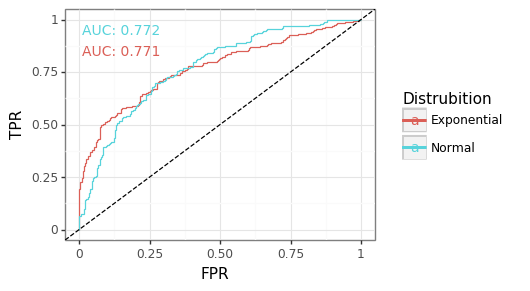

<ggplot: (8741319416265)>

In [59]:
target_auc = 0.75
mu_75 = np.sqrt(2) * stats.norm.ppf(target_auc)
lam_75 = target_auc / (1 - target_auc)
n, p = 500, 0.5

np.random.seed(2)
y_exp, s_exp = dgp_auc(n, p, lam_75, 'exp')
y_norm, s_norm = dgp_auc(n, p, mu_75, 'normal')
fpr_exp, tpr_exp, _ = roc_curve(y_exp, s_exp)
fpr_norm, tpr_norm, _ = roc_curve(y_norm, s_norm)
df = pd.concat([pd.DataFrame({'fpr':fpr_exp,'tpr':tpr_exp,'tt':'Exponential'}),
                pd.DataFrame({'fpr':fpr_norm,'tpr':tpr_norm, 'tt':'Normal'})])
tmp_txt = df.groupby('tt')[['fpr','tpr']].mean().reset_index().assign(fpr=[0.15,0.15],tpr=[0.85,0.95])
tmp_txt = tmp_txt.assign(lbl=['AUC: %0.3f' % auc_rank(y_exp, s_exp),
                    'AUC: %0.3f' % auc_rank(y_norm, s_norm)])

plotnine.options.figure_size = (4, 3)
gg_roc = (ggplot(df,aes(x='fpr',y='tpr',color='tt')) + theme_bw() + 
          geom_step() + labs(x='FPR',y='TPR') + 
          scale_color_discrete(name='Distrubition') + 
          geom_abline(slope=1,intercept=0,linetype='--') + 
          geom_text(aes(label='lbl'),size=10,data=tmp_txt))
gg_roc # ggtitle('ROC curve by distribution')

In [ ]:
# Get run-times for different sizes of n
p_seq = [0.1, 0.3, 0.5]
n_seq = np.arange(25, 500, 25)
nrun = 1000
c = 5

# if 'df_rt.csv' in os.listdir():
#     df_rt = pd.read_csv('df_rt.csv')
# else:
np.random.seed(nrun)
holder = []
for p in p_seq:
    print(p)
    for n in n_seq:
        cont = True
        m = c * n
        while cont:
            y, s = dgp_auc(n, p, 0, dist='normal')
            cont = sum(y) == 0
        ti_rand = timeit('auc_rand(y, s, m)',number=nrun,globals=globals())
        ti_rank = timeit('auc_rank(y, s)',number=nrun,globals=globals())
        ti_pair = timeit('auc_pair(y, s)',number=nrun,globals=globals())
        tmp = pd.DataFrame({'rand':ti_rand, 'rank':ti_rank, 'pair':ti_pair, 'p':p, 'n':n},index=[0])
        holder.append(tmp)
df_rt = pd.concat(holder).melt(['p','n'],None,'method')
df_rt.to_csv('df_rt.csv',index=False)

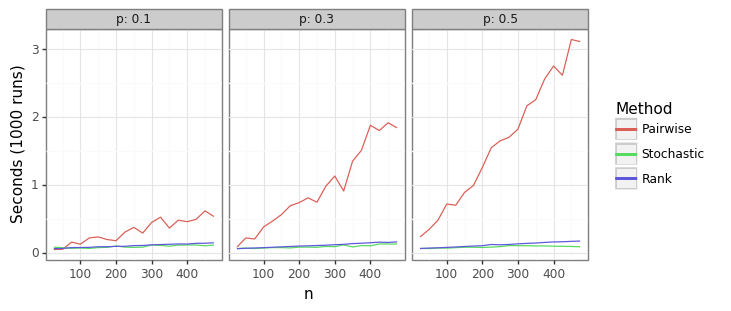

<ggplot: (8741319524533)>

In [60]:
plotnine.options.figure_size = (7, 3.0)
gg_ti = (ggplot(df_rt,aes(x='n',y='value',color='method')) + theme_bw() + 
         facet_wrap('~p',labeller=label_both) + geom_line() + 
         scale_color_discrete(name='Method',labels=['Pairwise','Stochastic','Rank']) + 
         labs(y='Seconds (1000 runs)', x='n'))
gg_ti  # ggtitle('AUROC run-time') + 

Figure 1 provides an example of two ROC curves coming from a Normal and Exponential distribution. Though the empirical AUROCs between the two curves is virtually identical, their respective sensitivity/specificity trade-offs are different. The Exponential distribution tends to have a more favourable sensitivity for high thresholds because of the right skew of the data. This figure is a reminder of some of the inherent limitations with using the AUROC as an evaluation measure. 

The significant runtime performance gains from using the ranking approach in \label{eq:auc_rank} is shown in Figure 2. The pairwise method from \eqref{eq:auc_pair} is many orders of magnitude slower once the sample size is more than a few dozen observations. The stochastic method's run time is shown to be slightly better than the ranking method. This is to be expected given that \eqref{eq:auc_rand} is linear in $n$. However, using the stochastic approach requires picking a permutation size that leads to sufficiently tight bounds around the point estimate. The simulations below show tight that bound across different numbers of draws. 

In [4]:
# Get the quality of the stochastic approximation
nsim = 100
n_seq = [100, 500, 1000]
c_seq = np.arange(1,11,1).astype(int)

if 'df_se.csv' in os.listdir():
    df_se = pd.read_csv('df_se.csv')
else:
    np.random.seed(nsim)
    holder = []
    for n in n_seq:
        print(n)
        holder_n = []
        for ii in range(nsim):
            y, s = dgp_auc(n, p, 0, dist='normal')
            gt_auc = auc_pair(y, s)
            sim_mat = np.array([[auc_rand(y, s, n*c) for c in c_seq] for x in range(nsim)])
            dat_err = np.std(gt_auc - sim_mat,axis=0)
            holder_n.append(dat_err)
        tmp = pd.DataFrame(np.array(holder_n)).melt(None,None,'c','se').assign(n=n)
        holder.append(tmp)
    df_se = pd.concat(holder).reset_index(None, True)
    df_se.c = df_se.c.map(dict(zip(list(range(len(c_seq))),c_seq)))
    df_se.to_csv('df_se.csv',index=False)
df_se = df_se.assign(sn=lambda x: pd.Categorical(x.n.astype(str),[str(z) for z in n_seq]))

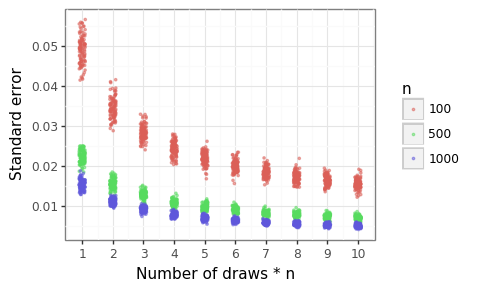

<ggplot: (8741327951337)>

In [61]:
plotnine.options.figure_size = (4, 3)
gg_se = (ggplot(df_se, aes(x='c',y='se',color='sn')) + 
         theme_bw() + labs(y='Standard error',x='Number of draws * n') + 
         geom_jitter(height=0,width=0.1,size=0.5,alpha=0.5) + 
         scale_color_discrete(name='n') + 
         scale_x_continuous(breaks=list(c_seq)))
gg_se  # ggtitle('Variation around point estimate from randomization method')

Figure 3 shows that the number of samples needed to get a small standard error to the ±1% is 4000 draws. In other words, if the actual empirical AUROC was 71%, we would expect 95% of the stochastic estimates to be around the 69-73% range. To get to the ±0.5% requires 10K draws. This shows that unless the user is happy to tolerate an error range of more than a percentage point, hundred of thousands of draws will likely be needed. 

## (3) Inference approaches

After reviewing the different approaches for calculating the point estimate of the empirical AUROC, attention can now be turned to doing inference on this term. Knowing that a classifier has an AUROC on 78% on a test set provides little information if there is no quantification of the uncertainty around this range. In this section, we'll discuss three different approaches for generating confidence intervals ([CIs](https://en.wikipedia.org/wiki/Confidence_interval)) which are the most common method of uncertainty quantification in frequentist statistics. A two-sided CI at the $1-\alpha$% level is a random variable that has the following property: $P([l, u] \in AUC ) \geq 1-\alpha$. In other words, the probability that the true AUROC is contained within this upper and lower bound, $l$ and $u$ (which are random variables), is at least $1-\alpha$%, meaning the true statistic of interest (the AUROC) fails to be *covered* by this interval at most $\alpha$% of the time. An exact CI will cover the true statistic of interest exactly $1-\alpha$% of the time, given the test maximum power.

The approaches below are by no means exhaustive. Readers are encouraged to review other [methods](https://arxiv.org/pdf/1804.05882.pdf) for other ideas.

### Approach #1: Asymptotic U

As was previously mentioned, the AUROC is equivalent to MNU test. The asymptotic properties of this statistic have been known for [more than 70 years](https://projecteuclid.org/euclid.aoms/1177730491). Under the null hypothesis assumption that $P(s_i^1 > s_i^0) = 0.5$, the asymptotic properties of such U statistics for ranks can be shown to be:

$$
\begin{align*}
z &= \frac{U - \mu_U}{\sigma_U} \sim N(0,1) \\ 
\mu_U &= \frac{n_0n_1}{2} \\
\sigma^2_U &= \frac{n_0n_1(n_0+n_1+1)}{12} \\
U &= n_1n_0 \cdot \max \{ AUC, (1-AUC) \} \\
\end{align*}
$$

There are additional corrections that need to be applied in the case of data which has ties, but I will not cover these continuity corrections here. There are two clear weaknesses to this approach. First, it appeals to the asymptotic normality of the $U$ statistic, which may be a poor approximation when $n$ is small. Second, this formula only makes sense for testing a null hypothesis of $AUC_0=0.5$. Notice that the constant in the denominator of the variance, 12, is the same as the constant in the variance of a [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution). This is not a coincidence as the distribution of rank order statistics is uniform when the data come from the same distribution. To estimate this constant for $AUC\neq 0.5$, monte carlo simulations will be needed. The estimates below will be used in later in the simulations.

$$
\begin{align*}
\sigma^2_U(AUC) &= \frac{n_0n_1(n_0+n_1+1)}{c(AUC)}
\end{align*}
$$


Even though it is somewhat computationally intensive to calculate these normalizing constants, their estimates hold true regardless of the sample of the sample sizes, as in $c(AUC;n_0,n_1)=c(AUC;n_0';n_1')$ for all $n_k, n_k' \in \mathbb{R}^+$.

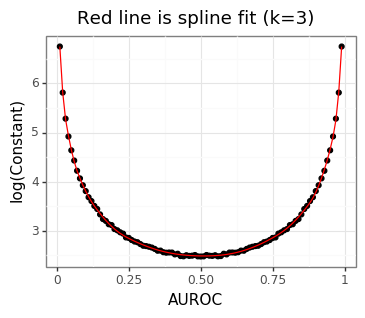

<ggplot: (8755706603569)>

In [130]:
# PRECOMPUTE THE VARIANCE CONSTANT...
if 'dat_var.csv' in os.listdir():
    dat_var = pd.read_csv('dat_var.csv')
else:
    np.random.seed(1)
    nsim = 10000
    n1, n0 = 500, 500
    den = n1 * n0
    auc_seq = np.arange(0.5, 1, 0.01)
    holder = np.zeros(len(auc_seq))
    for i, auc in enumerate(auc_seq):
        print(i)
        mu = np.sqrt(2) * stats.norm.ppf(auc)
        Eta = np.r_[np.random.randn(n1, nsim)+mu, np.random.randn(n0,nsim)]
        Y = np.r_[np.zeros([n1,nsim],dtype=int)+1, np.zeros([n0,nsim],dtype=int)]
        R1 = stats.rankdata(Eta,axis=0)[:n1]
        Amat = (R1.sum(0) - n1*(n1+1)/2) / den
        holder[i] = (n0+n1+1) / Amat.var() / den
    dat_var = pd.DataFrame({'auc':auc_seq, 'c':holder})
    dat_var = pd.concat([dat_var.iloc[1:].assign(auc=lambda x: 1-x.auc), dat_var]).sort_values('auc').reset_index(None, True)
    dat_var.to_csv('dat_var.csv', index=False)
# Calculate the spline
spl = UnivariateSpline(x=dat_var.auc, y=dat_var.c)
dat_spline = pd.DataFrame({'auc':dat_var.auc, 'spline':spl(dat_var.auc)})
plotnine.options.figure_size=(4,3)
gg_c = (ggplot(dat_var,aes(x='auc',y='np.log(c)')) + theme_bw() + 
        geom_point()+labs(y='log(Constant)',x='AUROC') + 
        geom_line(aes(x='auc',y='np.log(spline)'), data=dat_spline,color='red') + 
       ggtitle('Red line is spline fit (k=3)'))
gg_c

### Approach #2: Newcombe's Wald Method

A second approach is to use a (relatively) new approach from [Newcombe (2006)](https://onlinelibrary.wiley.com/doi/10.1002/sim.2324). Unlike the asymptotic approach above, the variance of the AUROC estimate is influenced by the level of the AUROC.

$$
\begin{align*}
\sigma^2_{AUC} &= \frac{AUC(1-AUC)}{(n_1-1)(n_0-1)} \cdot \Bigg[ 2n - 1 - \frac{3n-3}{(2-AUC)(1+AUC)} \Bigg]
\end{align*}
$$

Assuming $n_1 = c\cdot n$ then $O(\sigma^2_{AUC})=\frac{AUC(1-AUC)}{n}$, which is very similar to the variance of the binomial proportion (see [here](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)). 


### Approach #3: Bootstrapping ranks

The final inference approach is that of [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), which generates new copies of the statistic by resampling the data. Though the ability to get additional randomness by resampling rows of the data seems a little mysterious, if not dubious, it has a solid mathematical foundation. The bootstrap is equivalent to drawing from the empirical CDF (eCDF) of a random variable. Since the eCDF is known to be a [consistent](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem) estimate of the true CDF, the error of the bootstrap will naturally decrease as $n$ grows. The bootstrap has the attractive property that it is fully non-parametric and works from a broad class of statistics. Note that there is no one way to do the "bootstrap" for inference, and I compare three common approaches: i) quantile, ii) SE, iii) studentized. For a review of other approaches, see [here](http://users.stat.umn.edu/~helwig/notes/bootci-Notes.pdf). 


$$
\begin{align*}
\tilde{AUC}^{(k)} &= \frac{1}{n_1n_0} \sum_{i: y_i=1} \tilde{r}_i^{(k)} - \frac{n_1(n_1 +1)}{2} \\
\sigma^2_{BS} &= \frac{1}{K-1}\sum_{k=1}^K (\tilde{AUC}^{(k)} - \bar{\tilde{AUC}})
\end{align*}
$$

The $k^{th}$ bootstrap (out of $K$ total bootstraps), is generated by sampling, with replacement, the ranks of the positive score classes, and the bootstrap AUROC is calculated using the same formula from \eqref{eq:auc_rank}. Bootstrapping the ranks has the incredibly attractive property that the relative runtime is going to scale with the total number of bootstraps ($K$). If we had to recalculate the ranks for every bootstrap sample, then this would require an additional sorting call. The formulas for the three bootstrapping approaches are shown below for a $1-\alpha$% symmetric CI.

$$
\begin{align*}
\text{Quantile}& \\
[l, u] &= \big[\tilde{AUC}^{(k)}_{\lfloor\alpha/2\cdot K\rfloor}, \tilde{AUC}^{(k)}_{\lceil(1-\alpha/2)\cdot K\rceil} \big] \\
\\
\text{SE}& \\
[l, u] &= \big[AUC + \sigma_{BS}\cdot z_{\alpha/2}, AUC - \sigma_{BS}\cdot z_{\alpha/2}\big] \\
\\
\text{Studentized}& \\
[l, u] &= \big[AUC + \sigma_{BS}\cdot z_{\alpha/2}^*, AUC - \sigma_{BS}\cdot z_{1-\alpha/2}^*\big] \\
z_\alpha^* &= \Bigg[ \frac{\tilde{AUC}^{(k)} - AUC}{\sigma^{(k)}_{BS}} \Bigg]_{\lfloor\alpha\cdot K\rfloor}
\end{align*}
$$

The quantile approach simply takes the empirical $\alpha/2$ and $1-\alpha/2$ quantiles of the AUROC from its bootstrapped distribution. Though the quantile approach is easily for suited to skewed bootstrapped distributions (i.e. the CIs are not symmetric), it is known to be biased for sample sizes. The SE approach, or "classic" bootstrap, simply uses the bootstrapped AUROCs to estimate its empirical variance, and then use the standard normal approximation to generate CIs. The Studentized approach combines the estimate of the variance from the SE/classic approach but also takes into account the possibility for a skewed distribution. For each bootstrap sample, an additional $K$ (or some large number) samples are drawn, so that each bootstrapped sample has an estimate of its variance. These studentized, or normalized, scores are then used in place of the quantile from the normal distribution.

## (4) Simulations

Using a 10% class balance

Calculate the coverage for 80%, 90%, and 95% symmetric CIs.

In [125]:
"""
HELPER FUNCTION TO RETURN +- INTERVALS
A: array of AUCs
se: array of SEs
cv: critical values (can be array: will be treated as 1xk)
"""
def ret_lbub(A, se, cv, method):
    ub = cvec(A)+cvec(se)*rvec(cv)
    lb = cvec(A)-cvec(se)*rvec(cv)
    df_ub = pd.DataFrame(ub,columns=cn_cv).assign(bound='upper')
    df_lb = pd.DataFrame(lb,columns=cn_cv).assign(bound='lower')
    df = pd.concat([df_ub, df_lb]).assign(tt=method)
    return df

nsim = 1500
prop = 0.1
n_bs = 1000
n_student = 250
n_seq = [50, 100, 250, 1000]#[]
auc_seq = [0.5, 0.7, 0.9 ]  #"true" AUROC between the distributions
pvals = (1-np.array([0.8, 0.9, 0.95]))/2
crit_vals = np.abs(stats.norm.ppf(pvals))
cn_cv = ['p'+str(i+1) for i in range(len(pvals))]

np.random.seed(1)

if 'res.csv' in os.listdir():
    res = pd.read_csv('res.csv')
else:
    holder = []
    for n in n_seq:
        for auc in auc_seq:
            print('n: %i, AUROC: %0.2f' % (n, auc))
            n1 = int(np.round(n * prop))
            n0 = n - n1
            den = n1*n0
            mu = np.sqrt(2) * stats.norm.ppf(auc)
            Eta = np.r_[np.random.randn(n1, nsim)+mu, np.random.randn(n0,nsim)]
            Y = np.r_[np.zeros([n1,nsim],dtype=int)+1, np.zeros([n0,nsim],dtype=int)]
            # Calculate the AUCs across the columns
            R1 = stats.rankdata(Eta,axis=0)[:n1]
            Amat = (R1.sum(0) - n1*(n1+1)/2) / den
            # --- Approach 1: Asymptotic U --- #
            sd_u = np.sqrt((n0+n1+1)/spl(Amat)/den)
#             sd_u = np.sqrt(den * (n0 + n1 + 1) / 12) / den  # Notice I'm dividing by den to return to AUROC space
            df_asym = ret_lbub(Amat, sd_u, crit_vals, 'asymptotic')
            # --- Approach 2: Newcombe's wald
            sd_newcombe = np.sqrt(Amat*(1-Amat)/((n1-1)*(n0-1))*(2*n-1-((3*n-3)/((2-Amat)*(1+Amat)))))
            df_newcombe = ret_lbub(Amat, sd_newcombe, crit_vals, 'newcombe')
            # --- Approach 3: Bootstrap the ranks --- #
            R1_bs = pd.DataFrame(R1).sample(frac=n_bs,replace=True).values.reshape([n_bs]+list(R1.shape))
            auc_bs = (R1_bs.sum(1) - n1*(n1+1)/2) / den
            sd_bs = auc_bs.std(0,ddof=1)
            # - (i) Standard error method - #
            df_bs_se = ret_lbub(Amat, sd_bs, crit_vals, 'bootstrap_se')
            # - (ii) Quantile method - #
            df_lb_bs = pd.DataFrame(np.quantile(auc_bs,pvals,axis=0).T,columns=cn_cv).assign(bound='lower')
            df_ub_bs = pd.DataFrame(np.quantile(auc_bs,1-pvals,axis=0).T,columns=cn_cv).assign(bound='upper')
            df_bs_q = pd.concat([df_ub_bs, df_lb_bs]).assign(tt='bootstrap_q')
            # - (iii) Studentized - #
            se_bs_s = np.zeros(auc_bs.shape)
            for j in range(n_bs):
                R1_bs_s = pd.DataFrame(R1_bs[j]).sample(frac=n_student,replace=True).values.reshape([n_student]+list(R1.shape))
                auc_bs_s = (R1_bs_s.sum(1) - n1*(n1+1)/2) / den
                se_bs_s[j] = auc_bs_s.std(0,ddof=1)
            # Get the t-score dist
            t_bs = (auc_bs - rvec(Amat))/se_bs_s
            df_lb_t = pd.DataFrame(cvec(Amat) - cvec(sd_bs)*np.quantile(t_bs,1-pvals,axis=0).T,columns=cn_cv).assign(bound='lower')
            df_ub_t = pd.DataFrame(cvec(Amat) - cvec(sd_bs)*np.quantile(t_bs,pvals,axis=0).T,columns=cn_cv).assign(bound='upper')
            df_t = pd.concat([df_ub_t, df_lb_t]).assign(tt='bootstrap_s')        
            # Combine
            tmp_sim = pd.concat([df_asym, df_newcombe, df_bs_se, df_bs_q, df_t]).assign(auc=auc, n=n)
            holder.append(tmp_sim)
    # Merge and save
    res = pd.concat(holder)
    res = res.rename_axis('idx').reset_index().melt(['idx','bound','tt','auc','n'],cn_cv,'tpr')
    res = res.pivot_table('value',['idx','tt','auc','n','tpr'],'bound').reset_index()
    res.tpr = res.tpr.map(dict(zip(cn_cv, 1-2*pvals)))
    res = res.assign(is_covered=lambda x: (x.lower <= x.auc) & (x.upper >= x.auc))
    res.to_csv('res.csv',index=False)
res_cov = res.groupby(['tt','auc','n','tpr']).is_covered.mean().reset_index()
res_cov = res_cov.assign(sn = lambda x: pd.Categorical(x.n, x.n.unique()))
lvls_approach = ['asymptotic','newcombe','bootstrap_q','bootstrap_se','bootstrap_s']
lbls_approach = ['Asymptotic', 'Newcombe', 'BS (Quantile)', 'BS (SE)', 'BS (Studentized)']
res_cov = res_cov.assign(tt = lambda x: pd.Categorical(x.tt, lvls_approach).map(dict(zip(lvls_approach, lbls_approach))))
res_cov.rename(columns={'tpr':'CoverageTarget', 'auc':'AUROC'}, inplace=True)

n: 50, AUROC: 0.50


/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


n: 50, AUROC: 0.70
n: 50, AUROC: 0.90
n: 100, AUROC: 0.50
n: 100, AUROC: 0.70
n: 100, AUROC: 0.90
n: 250, AUROC: 0.50
n: 250, AUROC: 0.70
n: 250, AUROC: 0.90
n: 1000, AUROC: 0.50
n: 1000, AUROC: 0.70
n: 1000, AUROC: 0.90


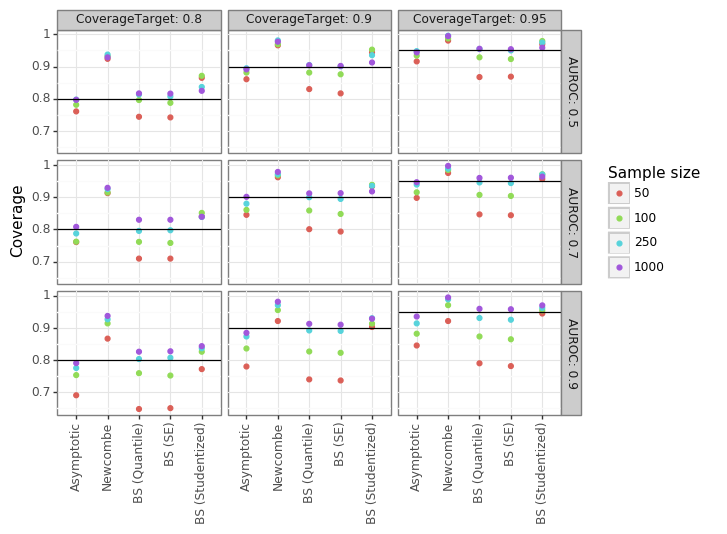

<ggplot: (8755706835657)>

In [126]:
tmp = pd.DataFrame({'CoverageTarget':1-2*pvals, 'ybar':1-2*pvals})
plotnine.options.figure_size = (6.5, 5)
gg_cov = (ggplot(res_cov, aes(x='tt', y='is_covered',color='sn')) + 
         theme_bw() + geom_point() + 
         facet_grid('AUROC~CoverageTarget',labeller=label_both) + 
         theme(axis_text_x=element_text(angle=90), axis_title_x=element_blank()) + 
         labs(y='Coverage') + 
         geom_hline(aes(yintercept='ybar'),data=tmp) + 
         scale_color_discrete(name='Sample size'))
gg_cov

## (5) Conclusion

Newcombe's method is the worst: SEs are at least 40% too large (code not shown) compared to asymptotic ones, as a result coverage is too high leading to almost no power. The Asymptotic approach and quantile/SE bootstrap approaches have SEs which are too small for small $n$ leading to undercoverage and an inflated type-I error rate. For sample sizes of at least 1000, the asymptotic intervals are quite accurate. The studentized bootstrap is by far the most accurate approach, especially for small sample sizes, and tends to be conservative (over-coverage). Overall it is the clear winner. However, it is also computationally the most costly, which means for large samples the asymptotic estimates may be better. 

### Ranking bootstraps?

In [430]:
if 'df_se.csv' in os.listdir():
    df_se = pd.read_csv('df_se.csv')
else:
    seed = 1
    np.random.seed(seed)
    n_bs, nsim = 1000, 1500
    n1, n0, mu = 25, 75, 1
    s = np.concatenate((np.random.randn(n1, nsim)+mu, np.random.randn(n0,nsim)))
    y = np.concatenate((np.repeat(1,n1),np.repeat(0,n0)))
    r = stats.rankdata(s,axis=0)[:n1]
    s1, s0 = s[:n1], s[n1:]
    r_bs = pd.DataFrame(r).sample(frac=n_bs,replace=True,random_state=seed).values.reshape([n_bs]+list(r.shape))
    s_bs1 = pd.DataFrame(s1).sample(frac=n_bs,replace=True,random_state=seed).values.reshape([n_bs]+list(s1.shape))
    s_bs0 = pd.DataFrame(s0).sample(frac=n_bs,replace=True,random_state=seed).values.reshape([n_bs]+list(s0.shape))
    s_bs = np.concatenate((s_bs1, s_bs0),axis=1)
    r_s_bs = stats.rankdata(s_bs,axis=1)[:,:n1,:]
    auc_bs = (r_bs.sum(1) - n1*(n1+1)/2)/(n1*n0)
    auc_s_bs = (r_s_bs.sum(1) - n1*(n1+1)/2)/(n1*n0)
    se_bs = auc_bs.std(0)
    se_s_bs = auc_s_bs.std(0)
    df_se = pd.DataFrame({'bs_r':se_bs, 'r_bs':se_s_bs})
    df_se.to_csv('df_se.csv', index=False)
print('Mean AUROC for bootstrapping ranks: %0.3f, and ranking bootstraps: %0.3f' % 
      (np.mean(df_se.bs_r),np.mean(df_se.r_bs)))

Mean AUROC for bootstraps ranks: 0.064, and ranking bootstraps: 0.054
